In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
from sklearn.model_selection import train_test_split #use this?
from sklearn.metrics import r2_score 
from scipy import stats
import xgboost as xgb

In [2]:
#test if epa python script worked
teamepaPath = r'D:\\Thesis2021\nba-movement-data\data\teamEPAGame'
playerepaPath = r'D:\\Thesis2021\nba-movement-data\data\playerEPAGame'
testplayerepa = pd.read_csv(playerepaPath + '/0021500001_playerEPA.csv')
testteamepa = pd.read_csv(teamepaPath + '/0021500001_teamEPA.csv')

In [3]:
teamgames = os.listdir(teamepaPath)
playergames = os.listdir(playerepaPath)
all_team_files = glob.glob(os.path.join(teamepaPath, "*.csv"))
all_player_files = glob.glob(os.path.join(playerepaPath, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_team_files)
concatenated_dfTeam   = pd.concat(df_from_each_file, ignore_index=True)
df_from_each_file = (pd.read_csv(f) for f in all_player_files)
concatenated_dfPlayer   = pd.concat(df_from_each_file, ignore_index=True)

In [4]:
names = {'T.J. McConnell':'TJ McConnell','J.J. Barea':'JJ Barea','C.J. Watson':'CJ Watson','Kelly Oubre Jr.':'Kelly Oubre',
        "Johnny O'Bryant III":"Johnny O'Bryant",'Glenn Robinson III':'Glenn Robinson','Otto Porter Jr.':'Otto Porter'}
concatenated_dfPlayer['Name'] = concatenated_dfPlayer.apply(lambda row: names[row['Name']] if (row['Name'] in names) else row['Name'],axis=1)

In [5]:
sortedTeams = concatenated_dfTeam.groupby(by='TeamName').sum().sort_values(by='EPA',ascending=False).reset_index()

In [6]:
sortedTeams.head(1)

,TeamName,EPA
0,Philadelphia 76ers,189.219276


One thing I can do is normalize by position/minutes per game

In [7]:
#input df with be some subset of the players_df
def getPlayerDataReady(df):
    cplayer = df.copy()
    cplayer['GamesPlayed'] = np.zeros(len(cplayer))
    GamesPlayedDF = cplayer[['Name','GamesPlayed']].groupby(by='Name').count().reset_index()
    sortedPlayers = df.groupby(by='Name').sum().sort_values(by='EPA',ascending=False).reset_index()
    positions = pd.read_csv(r'D:\Thesis2021\nba-movement-data\movement\positions.csv')
    positions = positions[['Player','Pos','MPG']]
    positions = positions.rename(columns={'Player':'Name'})
    withPos = sortedPlayers.merge(positions,how='left',on='Name') #bad thing about this is if someone is traded, they have multiple rows for MPG
    withPos = withPos.loc[pd.notnull(withPos['Pos'])]
    #now there's no null values - they were for players that played 1-4 games
    withPos = withPos.merge(GamesPlayedDF,how='left',on='Name')
    withPos['Pos'] = withPos.apply(lambda row: 'PG' if (row['Pos'] == 'SG-PG') else row['Pos'],axis=1) #thanks kirk
    withPos = withPos.drop_duplicates(subset=['Name'])
    
    posAvg = {}
    for each in withPos['Pos'].unique():
        totalMinutes = 0
        for x,y in zip(withPos.loc[withPos['Pos'] == each,'MPG'].tolist(),withPos.loc[withPos['Pos'] == each,'GamesPlayed'].tolist()):
            totalMinutes += x*y
        posAvg[each] = withPos.loc[withPos['Pos'] == each,'EPA'].sum() / totalMinutes
    #print(posAvg) #just for fun
    withPos['NormalizedEPA'] = withPos.apply(lambda row: round(row['EPA'] - posAvg[row['Pos']]*row['GamesPlayed']*row['MPG'],3),axis=1)
    withPos['NormalizedEPAperGame'] = withPos.apply(lambda row: round(row['NormalizedEPA'] / row['GamesPlayed'],3),axis=1)
    noEPA = withPos.drop(columns=['EPA'])
    return noEPA

# Here are some results

In [8]:
noEPA = getPlayerDataReady(concatenated_dfPlayer)
noEPA.sort_values(by='NormalizedEPA',ascending=False).drop_duplicates(subset='Pos').reset_index(drop=True).head(5)

,Name,Pos,MPG,GamesPlayed,NormalizedEPA,NormalizedEPAperGame
0,Goran Dragic,SG,32.8,28,323.073,11.538
1,Ricky Rubio,PG,30.6,28,247.413,8.836
2,Kristaps Porzingis,PF,28.4,37,101.827,2.752
3,LeBron James,SF,35.6,29,84.423,2.911
4,DeAndre Jordan,C,33.7,28,68.213,2.436


In [10]:
justPGs = noEPA.loc[noEPA['Pos'] == 'PG'].sort_values(by='NormalizedEPA',ascending=False).reset_index(drop=True).head(5)
justPGs.style.set_table_attributes("style='display:inline'").set_caption('Top PGs in Normalized EPA for 2015-2016')

,Name,Pos,MPG,GamesPlayed,NormalizedEPA,NormalizedEPAperGame
0,Ricky Rubio,PG,30.600000,28,247.413000,8.836000
1,Damian Lillard,PG,35.700000,34,205.282000,6.038000
2,Derrick Rose,PG,31.800000,26,129.536000,4.982000
3,Isaiah Thomas,PG,32.200000,34,123.833000,3.642000
4,Reggie Jackson,PG,30.700000,34,123.024000,3.618000


# some code to get games played to filter for stability check

In [10]:
gamesTotal1 = concatenated_dfPlayer[0:4930].groupby(by='Name').count().reset_index()
gamesTotal2 = concatenated_dfPlayer[4930:].groupby(by='Name').count().reset_index()
gamesTotal1 = gamesTotal1.rename(columns={'EPA':'GamesPlayed'})
gamesTotal2 = gamesTotal2.rename(columns={'EPA':'GamesPlayed'})
allgamesTotal = gamesTotal1.merge(gamesTotal2,how='outer',on='Name',suffixes=('1','2'))
allgamesTotal.fillna(0.0,inplace=True)

In [11]:
allgamesTotal.loc[(allgamesTotal['GamesPlayed1'] >= 10) & (allgamesTotal['GamesPlayed2'] >= 10)]

,Name,GamesPlayed1,GamesPlayed2
1,Aaron Gordon,17.0,14.0
3,Al Horford,20.0,14.0
5,Al-Farouq Aminu,17.0,19.0
7,Alex Len,15.0,13.0
8,Alexis Ajinca,14.0,13.0
...,...,...,...
389,Wesley Matthews,14.0,17.0
390,Will Barton,17.0,16.0
392,Zach LaVine,17.0,17.0
393,Zach Randolph,13.0,16.0


In [12]:
tenPlusGames = allgamesTotal.loc[(allgamesTotal['GamesPlayed1'] >= 10) & (allgamesTotal['GamesPlayed2'] >= 10)].copy()
tenPlusGames = tenPlusGames[['Name']]

In [13]:
len(concatenated_dfPlayer)

9860

In [14]:
firsthalf = getPlayerDataReady(concatenated_dfPlayer[:4930])
secondhalf = getPlayerDataReady(concatenated_dfPlayer[4930:])
firsthalf = firsthalf[['Name','NormalizedEPAperGame']]
secondhalf = secondhalf[['Name','NormalizedEPAperGame']]
bothhalves = firsthalf.merge(secondhalf,how='inner',on='Name',suffixes=('1','2'))

In [15]:
bothhalves.head(2)

,Name,NormalizedEPAperGame1,NormalizedEPAperGame2
0,Damian Lillard,5.875,6.202
1,Jarrett Jack,7.054,2.783


In [16]:
#this makes it so we must have 10 games in both halves
bothhalves = tenPlusGames.merge(bothhalves,how='left',on='Name')

R squared value: 0.3449


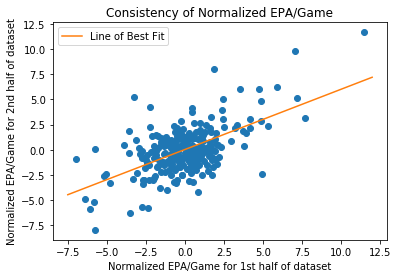

In [17]:
plt.figure()
xvalues = bothhalves['NormalizedEPAperGame1'].tolist()
yvalues = bothhalves['NormalizedEPAperGame2'].tolist()
corr_matrix = np.corrcoef(xvalues, yvalues)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R squared value:', round(R_sq,4)) 
plt.plot(xvalues,yvalues,'o')
plt.xlabel('Normalized EPA/Game for 1st half of dataset')
plt.ylabel('Normalized EPA/Game for 2nd half of dataset')
plt.title('Consistency of Normalized EPA/Game')
m,b = np.polyfit(xvalues,yvalues,1)
xpoints = np.linspace(-7.5,12,200)
plt.plot(xpoints,xpoints*m + b,label='Line of Best Fit')
plt.legend()
plt.show()

# correlation with other stats

In [72]:
#these stats from basketball reference
brefStats = pd.read_csv(r'D:\Thesis2021\nba-movement-data\movement\PER.csv')
brefStats['Name'] = brefStats.apply(lambda row: names[row['Player']] if (row['Player'] in names) else row['Player'],axis=1)
per = brefStats[['Name','PER']].copy()
noEPAandPER = noEPA.loc[noEPA['GamesPlayed'] > 20]
noEPAandPER = noEPAandPER[['Name','Pos','NormalizedEPAperGame']].merge(per,how='inner',on='Name')

R squared value: 0.0032


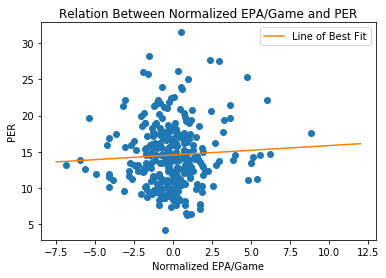

In [62]:
plt.figure()
xvalues = noEPAandPER['NormalizedEPAperGame'].tolist()
yvalues = noEPAandPER['PER'].tolist()
corr_matrix = np.corrcoef(xvalues, yvalues)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R squared value:', round(R_sq,4)) 
plt.plot(xvalues,yvalues,'o')
plt.xlabel('Normalized EPA/Game')
plt.ylabel('PER')
plt.title('Relation Between Normalized EPA/Game and PER')
m,b = np.polyfit(xvalues,yvalues,1)
xpoints = np.linspace(-7.5,12,200)
plt.plot(xpoints,xpoints*m + b,label='Line of Best Fit')
plt.legend()
plt.show()

In [99]:
obpm = brefStats[['Name','OBPM']].copy()
noEPAandObpm = noEPA.loc[noEPA['GamesPlayed'] > 20]
noEPAandObpm = noEPAandObpm[['Name','Pos','NormalizedEPAperGame']].merge(obpm,how='inner',on='Name')

R squared value: 0.0089


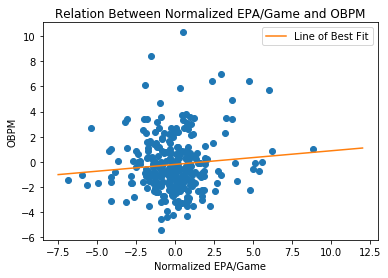

In [64]:
plt.figure()
xvalues = noEPAandObpm['NormalizedEPAperGame'].tolist()
yvalues = noEPAandObpm['OBPM'].tolist()
corr_matrix = np.corrcoef(xvalues, yvalues)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R squared value:', round(R_sq,4)) 
plt.plot(xvalues,yvalues,'o')
plt.xlabel('Normalized EPA/Game')
plt.ylabel('OBPM')
plt.title('Relation Between Normalized EPA/Game and OBPM')
m,b = np.polyfit(xvalues,yvalues,1)
xpoints = np.linspace(-7.5,12,200)
plt.plot(xpoints,xpoints*m + b,label='Line of Best Fit')
plt.legend()
plt.show()

R squared value: 0.7808


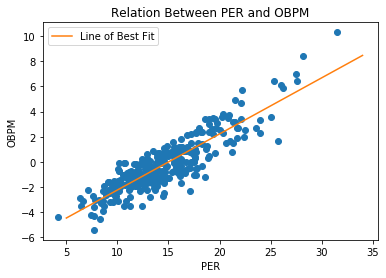

In [66]:
plt.figure()
xvalues = noEPAandPER['PER'].tolist()
yvalues = noEPAandObpm['OBPM'].tolist()
corr_matrix = np.corrcoef(xvalues, yvalues)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R squared value:', round(R_sq,4)) 
plt.plot(xvalues,yvalues,'o')
plt.xlabel('PER')
plt.ylabel('OBPM')
plt.title('Relation Between PER and OBPM')
m,b = np.polyfit(xvalues,yvalues,1)
xpoints = np.linspace(5,34,200)
plt.plot(xpoints,xpoints*m + b,label='Line of Best Fit')
plt.legend()
plt.show()

R squared value for PG : 0.0505
R squared value for SG : 0.0011
R squared value for SF : 0.0018
R squared value for PF : 0.0252
R squared value for C : 0.0594
R squared value for All : 0.0032


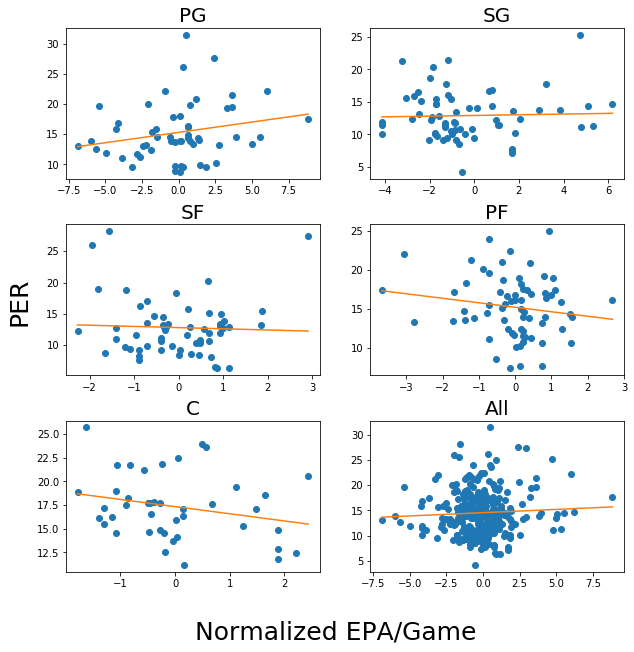

In [102]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
index = 0
numbers = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
for pos in ['PG','SG','SF','PF','C','All']:
    if pos != 'All':
        onePos = noEPAandPER.loc[noEPAandPER['Pos'] == pos].copy()
    else:
        onePos = noEPAandPER.copy()
    xvalues = onePos['NormalizedEPAperGame'].tolist()
    yvalues = onePos['PER'].tolist()
    corr_matrix = np.corrcoef(xvalues, yvalues)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    print('R squared value for',pos,':', round(R_sq,4)) 
    thisNumber1 = numbers[index][0]
    thisNumber2 = numbers[index][1]
    index += 1
    axs[thisNumber1,thisNumber2].plot(xvalues,yvalues,'o')
    #plt.xlabel('Normalized EPA/Game')
    #plt.ylabel('PER')
    axs[thisNumber1,thisNumber2].set_title(pos,fontsize=20)
    m,b = np.polyfit(xvalues,yvalues,1)
    xstart = min(xvalues)
    xend = max(xvalues)
    xpoints = np.linspace(xstart,xend,200)
    axs[thisNumber1,thisNumber2].plot(xpoints,xpoints*m + b,label='Line of Best Fit')
    plt.setp(axs[thisNumber1,thisNumber2].get_xticklabels(),visible=True)
    #plt.legend()
fig.subplots_adjust(hspace=0.3)
fig.text(0.5, 0.04,'Normalized EPA/Game', ha='center', va='center',fontsize=25) #0.35,0.04
fig.text(0.06, 0.5, 'PER', ha='center', va='center', rotation='vertical',fontsize=25)

plt.show()

R squared value for PG : 0.0623
R squared value for SG : 0.0068
R squared value for SF : 0.0008
R squared value for PF : 0.0159
R squared value for C : 0.0009
R squared value for All : 0.0089


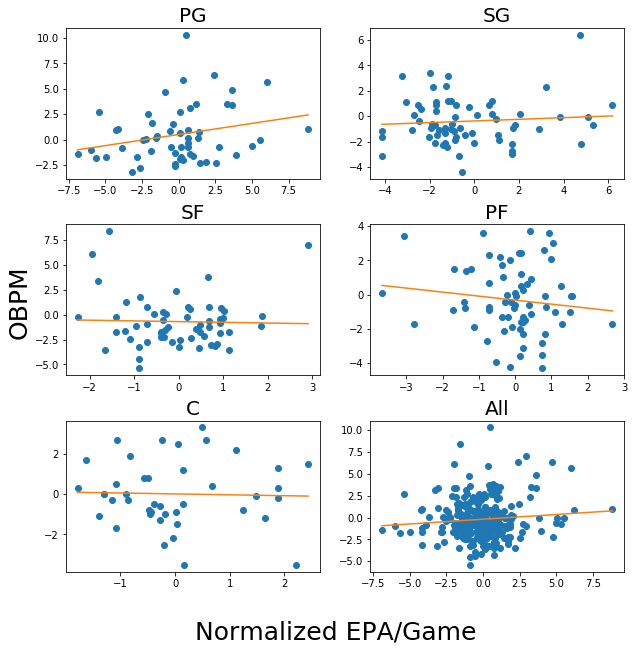

In [101]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
index = 0
numbers = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
for pos in ['PG','SG','SF','PF','C','All']:
    if pos != 'All':
        onePos = noEPAandObpm.loc[noEPAandObpm['Pos'] == pos].copy()
    else:
        onePos = noEPAandObpm.copy()
    xvalues = onePos['NormalizedEPAperGame'].tolist()
    yvalues = onePos['OBPM'].tolist()
    corr_matrix = np.corrcoef(xvalues, yvalues)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    print('R squared value for',pos,':', round(R_sq,4)) 
    thisNumber1 = numbers[index][0]
    thisNumber2 = numbers[index][1]
    index += 1
    axs[thisNumber1,thisNumber2].plot(xvalues,yvalues,'o')
    #plt.xlabel('Normalized EPA/Game')
    #plt.ylabel('PER')
    axs[thisNumber1,thisNumber2].set_title(pos,fontsize=20)
    m,b = np.polyfit(xvalues,yvalues,1)
    xstart = min(xvalues)
    xend = max(xvalues)
    xpoints = np.linspace(xstart,xend,200)
    axs[thisNumber1,thisNumber2].plot(xpoints,xpoints*m + b,label='Line of Best Fit')
    plt.setp(axs[thisNumber1,thisNumber2].get_xticklabels(),visible=True)
    #plt.legend()
fig.subplots_adjust(hspace=0.3)
fig.text(0.5, 0.04,'Normalized EPA/Game', ha='center', va='center',fontsize=25) #0.35,0.04
fig.text(0.06, 0.5, 'OBPM', ha='center', va='center', rotation='vertical',fontsize=25)

plt.show()